# 📦 Instalação de Dependências

Primeiro, vamos instalar a biblioteca LTNtorch necessária para o projeto.

In [1]:
!pip install LTNtorch

In [2]:
import torch
import torch.nn as nn
import numpy as np
import ltn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import json
from collections import defaultdict

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


# 🎨 Gerador de Dados CLEVR Simplificado

Esta classe é responsável por:
- Gerar cenários aleatórios com 25 objetos
- Cada objeto tem 11 características (posição, cor, forma, tamanho)
- Visualizar os cenários gerados em 2D

## Estrutura do Vetor de Características (11 dimensões):
- **[0, 1]**: Posição x, y (coordenadas normalizadas 0.0 a 1.0)
- **[2, 3, 4]**: Cor One-Hot (Vermelho, Verde, Azul)
- **[5, 6, 7, 8, 9]**: Forma One-Hot (Círculo, Quadrado, Cilindro, Cone, Triângulo)
- **[10]**: Tamanho (Pequeno = 0.0, Grande = 1.0)


In [3]:
class ClevrSimplified:
    """
    Gerador de dados CLEVR simplificado para raciocínio espacial.

    Attributes:
        n_objects (int): Número de objetos no cenário (padrão: 25)
        feature_dim (int): Dimensão do vetor de características (11)
        shape_names (list): Nomes das formas disponíveis
        color_names (list): Nomes das cores disponíveis
        size_names (list): Nomes dos tamanhos disponíveis
    """

    def __init__(self, n_objects=25):
        self.n_objects = n_objects
        self.feature_dim = 11
        self.shape_names = ['Circle', 'Square', 'Cylinder', 'Cone', 'Triangle']
        self.color_names = ['Red', 'Green', 'Blue']
        self.size_names = ['Small', 'Big']

    def generate(self):
        """
        Gera um cenário aleatório com n_objects objetos.

        Returns:
            tuple: (data, shapes_idx, sizes) onde:
                - data: tensor (n_objects, 11) com características dos objetos
                - shapes_idx: tensor (n_objects,) com índices das formas
                - sizes: tensor (n_objects,) com tamanhos (0.0 ou 1.0)
        """
        # Posições aleatórias normalizadas [0, 1]
        pos = torch.rand((self.n_objects, 2))

        # Cores one-hot (3 opções: R, G, B)
        colors = torch.eye(3)[torch.randint(0, 3, (self.n_objects,))]

        # Formas one-hot (5 opções)
        shapes_idx = torch.randint(0, 5, (self.n_objects,))
        shapes = torch.eye(5)[shapes_idx]

        # Tamanhos (0 = pequeno, 1 = grande)
        sizes = torch.randint(0, 2, (self.n_objects, 1)).float()

        # Concatenar todas as características
        data = torch.cat([pos, colors, shapes, sizes], dim=1)

        return data, shapes_idx, sizes.squeeze()

    def plot_scene(self, data, title="CLEVR Scene"):
        """
        Visualiza o cenário 2D com formas geométricas realistas.

        Args:
            data (torch.Tensor): Tensor (n_objects, 11) com dados dos objetos
            title (str): Título do gráfico
        """
        fig, ax = plt.subplots(figsize=(12, 12))
        colors_map = {0: 'red', 1: 'green', 2: 'blue'}

        for i in range(data.shape[0]):
            # Extrair características do objeto
            x, y = data[i, 0].item(), data[i, 1].item()
            color_idx = torch.argmax(data[i, 2:5]).item()
            shape_idx = torch.argmax(data[i, 5:10]).item()
            size = data[i, 10].item()

            color = colors_map[color_idx]
            scale = 1.5 if size == 1.0 else 0.8  # Escala para grande/pequeno

            # ============================================
            # CÍRCULO (shape 0)
            # ============================================
            if shape_idx == 0:
                from matplotlib.patches import Circle
                radius = 0.025 * scale
                circle = Circle((x, y), radius, facecolor=color,
                              edgecolor='black', linewidth=2, alpha=0.85)
                ax.add_patch(circle)

            # ============================================
            # QUADRADO (shape 1)
            # ============================================
            elif shape_idx == 1:
                from matplotlib.patches import Rectangle
                side = 0.045 * scale
                square = Rectangle((x - side/2, y - side/2), side, side,
                                  facecolor=color, edgecolor='black',
                                  linewidth=2, alpha=0.85)
                ax.add_patch(square)

            # ============================================
            # CILINDRO (shape 2) - Retângulo + 2 elipses
            # ============================================
            elif shape_idx == 2:
                from matplotlib.patches import Rectangle, Ellipse

                width = 0.028 * scale
                height = 0.055 * scale

                # Corpo do cilindro
                body = Rectangle((x - width/2, y - height/2), width, height,
                               facecolor=color, edgecolor='black',
                               linewidth=2, alpha=0.85, zorder=2)
                ax.add_patch(body)

                # Base inferior
                base = Ellipse((x, y - height/2), width, width*0.4,
                             facecolor=color, edgecolor='black',
                             linewidth=2, alpha=0.85, zorder=1)
                ax.add_patch(base)

                # Topo superior (efeito 3D)
                import matplotlib.colors as mcolors
                lighter_color = mcolors.to_rgba(color, alpha=1.0)
                top = Ellipse((x, y + height/2), width, width*0.4,
                            facecolor=lighter_color, edgecolor='black',
                            linewidth=2, alpha=0.95, zorder=3)
                ax.add_patch(top)

            # ============================================
            # CONE (shape 3) - Triângulo + elipse na base
            # ============================================
            elif shape_idx == 3:
                from matplotlib.patches import Polygon, Ellipse
                import numpy as np

                side_length = 0.050 * scale
                height = side_length * np.sqrt(3) / 2
                base_width = 0.024 * scale

                # Base do cone
                base = Ellipse((x, y - height/2), base_width*2.0, base_width*0.4,
                             facecolor=color, edgecolor='black',
                             linewidth=2, alpha=0.85, zorder=1)
                ax.add_patch(base)

                # Corpo do cone
                cone_body = Polygon([
                    [x - base_width, y - height/2],
                    [x + base_width, y - height/2],
                    [x, y + height/2]
                ], facecolor=color, edgecolor='black',
                   linewidth=2, alpha=0.85, zorder=2)
                ax.add_patch(cone_body)

            # ============================================
            # TRIÂNGULO (shape 4) - Triângulo equilátero
            # ============================================
            elif shape_idx == 4:
                from matplotlib.patches import Polygon
                import numpy as np

                side_length = 0.050 * scale
                height_tri = side_length * np.sqrt(3) / 2

                triangle = Polygon([
                    [x, y + 2*height_tri/3],
                    [x - side_length/2, y - height_tri/3],
                    [x + side_length/2, y - height_tri/3]
                ], facecolor=color, edgecolor='black',
                   linewidth=2, alpha=0.85)
                ax.add_patch(triangle)

        # Configurar eixos e legenda
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
        ax.set_xlabel('X Position', fontsize=12, fontweight='bold')
        ax.set_ylabel('Y Position', fontsize=12, fontweight='bold')
        ax.set_title(title, fontsize=16, fontweight='bold', pad=20)

        # Legenda com formas
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
                   markersize=12, label='Circle', markeredgecolor='black', linewidth=2),
            Line2D([0], [0], marker='s', color='w', markerfacecolor='gray',
                   markersize=12, label='Square', markeredgecolor='black', linewidth=2),
            Line2D([0], [0], marker='8', color='w', markerfacecolor='gray',
                   markersize=12, label='Cylinder', markeredgecolor='black', linewidth=2),
            Line2D([0], [0], marker='v', color='w', markerfacecolor='gray',
                   markersize=12, label='Cone', markeredgecolor='black', linewidth=2),
            Line2D([0], [0], marker='^', color='w', markerfacecolor='gray',
                   markersize=12, label='Triangle', markeredgecolor='black', linewidth=2)
        ]

        legend = ax.legend(handles=legend_elements, loc='upper right',
                          fontsize=11, framealpha=0.95, edgecolor='black')
        legend.set_title('Shapes', prop={'size': 12, 'weight': 'bold'})

        plt.tight_layout()
        plt.show()

# Instanciar gerador
data_gen = ClevrSimplified(n_objects=25)
print("✅ Gerador de dados criado!")


✅ Gerador de dados criado!


# 📊 Dataset Fixo de Treinamento

Este dataset foi cuidadosamente construído com 25 objetos de diferentes:
- **Cores**: Vermelho, Verde, Azul
- **Formas**: Círculo, Quadrado, Cilindro, Cone, Triângulo
- **Tamanhos**: Pequeno (0.0) e Grande (1.0)

O dataset é usado para treinar a rede a reconhecer padrões espaciais e propriedades dos objetos.


✅ Dataset de treino carregado: torch.Size([25, 11])

📊 Visualizando cenário de TREINO:


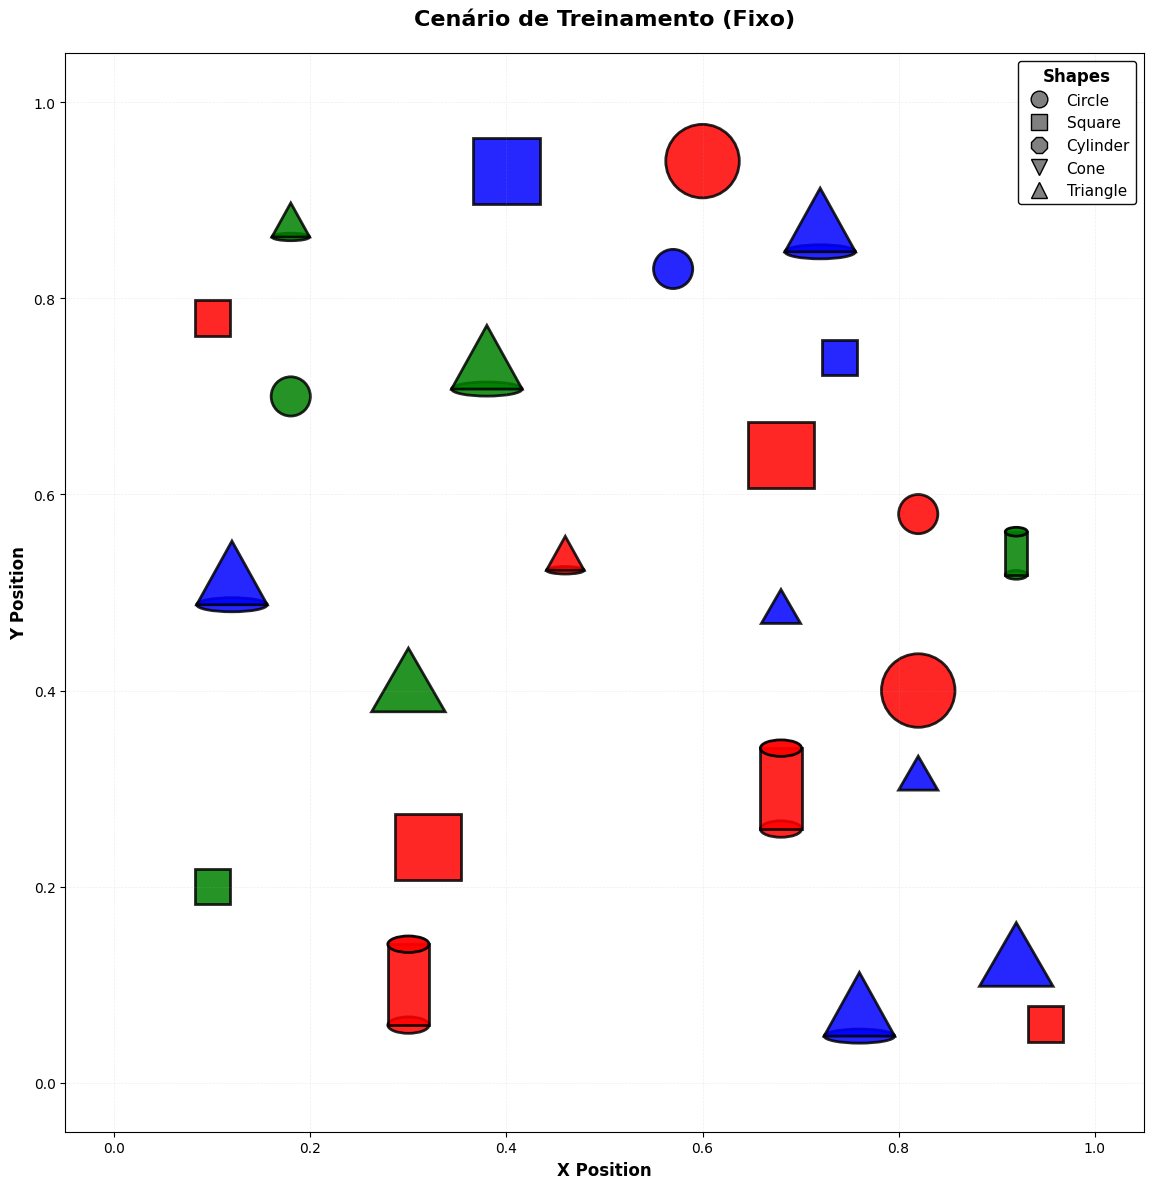

In [4]:
meu_dataset_fixo = [
    # ======================
    # Objetos Vermelhos (10)
    # ======================
    [0.10, 0.78, 1, 0, 0, 0, 1, 0, 0, 0, 0.0],  # Quadrado vermelho pequeno
    [0.60, 0.94, 1, 0, 0, 1, 0, 0, 0, 0, 1.0],  # Círculo vermelho grande
    [0.68, 0.64, 1, 0, 0, 0, 1, 0, 0, 0, 1.0],  # Quadrado vermelho grande
    [0.82, 0.58, 1, 0, 0, 1, 0, 0, 0, 0, 0.0],  # Círculo vermelho pequeno
    [0.82, 0.40, 1, 0, 0, 1, 0, 0, 0, 0, 1.0],  # Círculo vermelho grande
    [0.46, 0.54, 1, 0, 0, 0, 0, 0, 1, 0, 0.0],  # Cone vermelho pequeno
    [0.68, 0.30, 1, 0, 0, 0, 0, 1, 0, 0, 1.0],  # Cilindro vermelho grande
    [0.95, 0.06, 1, 0, 0, 0, 1, 0, 0, 0, 0.0],  # Quadrado vermelho pequeno
    [0.32, 0.24, 1, 0, 0, 0, 1, 0, 0, 0, 1.0],  # Quadrado vermelho grande
    [0.30, 0.10, 1, 0, 0, 0, 0, 1, 0, 0, 1.0],  # Cilindro vermelho grande

    # ======================
    # Objetos Azuis (9)
    # ======================
    [0.76, 0.08, 0, 0, 1, 0, 0, 0, 1, 0, 1.0],  # Cone azul grande
    [0.92, 0.12, 0, 0, 1, 0, 0, 0, 0, 1, 1.0],  # Triângulo azul grande
    [0.82, 0.31, 0, 0, 1, 0, 0, 0, 0, 1, 0.0],  # Triângulo azul pequeno
    [0.68, 0.48, 0, 0, 1, 0, 0, 0, 0, 1, 0.0],  # Triângulo azul pequeno
    [0.74, 0.74, 0, 0, 1, 0, 1, 0, 0, 0, 0.0],  # Quadrado azul pequeno
    [0.72, 0.88, 0, 0, 1, 0, 0, 0, 1, 0, 1.0],  # Cone azul grande
    [0.57, 0.83, 0, 0, 1, 1, 0, 0, 0, 0, 0.0],  # Círculo azul pequeno
    [0.40, 0.93, 0, 0, 1, 0, 1, 0, 0, 0, 1.0],  # Quadrado azul grande
    [0.12, 0.52, 0, 0, 1, 0, 0, 0, 1, 0, 1.0],  # Cone azul grande

    # ======================
    # Objetos Verdes (6)
    # ======================
    [0.10, 0.20, 0, 1, 0, 0, 1, 0, 0, 0, 0.0],  # Quadrado verde pequeno
    [0.30, 0.40, 0, 1, 0, 0, 0, 0, 0, 1, 1.0],  # Triângulo verde grande
    [0.18, 0.70, 0, 1, 0, 1, 0, 0, 0, 0, 0.0],  # Círculo verde pequeno
    [0.38, 0.74, 0, 1, 0, 0, 0, 0, 1, 0, 1.0],  # Cone verde grande
    [0.18, 0.88, 0, 1, 0, 0, 0, 0, 1, 0, 0.0],  # Cone verde pequeno
    [0.92, 0.54, 0, 1, 0, 0, 0, 1, 0, 0, 0.0],  # Cilindro verde pequeno
]

# Converter para tensor PyTorch
data_train = torch.tensor(meu_dataset_fixo, dtype=torch.float32)

print(f"✅ Dataset de treino carregado: {data_train.shape}")
print("\n📊 Visualizando cenário de TREINO:")
data_gen.plot_scene(data_train, "Cenário de Treinamento (Fixo)")

# Criar variáveis LTN para o dataset de treino
x = ltn.Variable("x", data_train)
y = ltn.Variable("y", data_train)
z = ltn.Variable("z", data_train)


# 🧠 Arquiteturas de Redes Neurais

Nesta seção, definimos três tipos de modelos:

1. **MLP (Multi-Layer Perceptron)**: Para predicados unários (propriedades individuais)
   - Entrada: 11 características de um objeto
   - Saída: Probabilidade [0, 1] de satisfazer o predicado
   
2. **SpatialMLP**: Para predicados binários (relações espaciais)
   - Entrada: 22 características (concatenação de dois objetos)
   - Saída: Probabilidade [0, 1] da relação ser verdadeira
   
3. **Modelos Fixos**: Para relações baseadas em regras determinísticas
   - CloseToModel: Usa kernel Gaussiano para proximidade
   - SameSizeModel: Compara tamanhos exatos
   - EqualityModel: Verifica se são o mesmo objeto


In [5]:
class MLP(nn.Module):
    """
    Rede neural para predicados unários (propriedades de um único objeto).

    Arquitetura: 11 → 16 → 16 → 1 com ativação ELU e Sigmoid final.
    """
    def __init__(self, layer_sizes=(11, 16, 16, 1)):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:
                layers.append(nn.ELU())  # Ativação intermediária
            else:
                layers.append(nn.Sigmoid())  # Saída entre 0 e 1
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class SpatialMLP(nn.Module):
    """
    Rede neural para predicados binários (relações entre dois objetos).

    Arquitetura: 22 → 32 → 16 → 1 com ativação ELU e Sigmoid final.
    """
    def __init__(self, layer_sizes=(22, 32, 16, 1)):
        super(SpatialMLP, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:
                layers.append(nn.ELU())
            else:
                layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        # Concatenar características dos dois objetos
        cat = torch.cat([x, y], dim=-1)
        return self.model(cat)


class CloseToModel(nn.Module):
    """
    Modelo fixo (não treinável) para proximidade espacial.

    Usa kernel Gaussiano: exp(-2 * distância²)
    Quanto menor a distância, maior a proximidade (próximo de 1.0)
    """
    def forward(self, x, y):
        # Calcular distância quadrática entre posições [0:2]
        dist_sq = torch.sum((x[..., :2] - y[..., :2]) ** 2, dim=-1)
        return torch.exp(-2.0 * dist_sq)


class SameSizeModel(nn.Module):
    """
    Modelo fixo para verificar se dois objetos têm o mesmo tamanho.

    Retorna 1.0 se tamanhos iguais, 0.0 caso contrário.
    """
    def forward(self, x, y):
        # Comparar valores na posição [10] (tamanho)
        same = (x[..., 10] == y[..., 10]).float()
        return same


class EqualityModel(nn.Module):
    """
    Modelo fixo para verificar se dois objetos são o mesmo.

    Usa threshold de distância muito pequeno (1e-6) nas posições.
    """
    def forward(self, x, y):
        # Calcular diferença de posição
        pos_diff = torch.sum((x[..., :2] - y[..., :2]) ** 2, dim=-1)
        # Threshold muito pequeno para considerar "mesma posição"
        return (pos_diff < 1e-6).float()


print("✅ Arquiteturas de redes neurais definidas!")


✅ Arquiteturas de redes neurais definidas!


# 🔧 Instanciação de Modelos e Predicados

Aqui criamos instâncias dos modelos e os envolvemos com `ltn.Predicate` para uso em fórmulas lógicas.

## Predicados Unários (Propriedades):
- **Formas**: IsCircle, IsSquare, IsCylinder, IsCone, IsTriangle
- **Tamanhos**: IsSmall, IsBig
- **Cores**: IsRed, IsGreen, IsBlue

## Predicados Binários (Relações):
- **Espaciais Horizontais**: LeftOf, RightOf
- **Espaciais Verticais**: Below, Above
- **Empilhamento**: CanStack
- **Fixos**: CloseTo, SameSize, Equal


In [6]:
# ============================================
# Instanciar modelos para predicados unários
# ============================================
model_circle = MLP()
model_square = MLP()
model_cylinder = MLP()
model_cone = MLP()
model_triangle = MLP()
model_small = MLP()
model_big = MLP()
model_red = MLP()
model_green = MLP()
model_blue = MLP()

# ============================================
# Instanciar modelos para predicados binários
# ============================================
model_left = SpatialMLP()
model_right = SpatialMLP()
model_below = SpatialMLP()
model_above = SpatialMLP()
model_stack = SpatialMLP()

# ============================================
# Instanciar modelos fixos (não treináveis)
# ============================================
model_close_to = CloseToModel()
model_same_size = SameSizeModel()
model_equal = EqualityModel()

# ============================================
# Criar Predicados LTN
# ============================================

# Predicados de Forma
IsCircle = ltn.Predicate(model_circle)
IsSquare = ltn.Predicate(model_square)
IsCylinder = ltn.Predicate(model_cylinder)
IsCone = ltn.Predicate(model_cone)
IsTriangle = ltn.Predicate(model_triangle)

# Predicados de Tamanho
IsSmall = ltn.Predicate(model_small)
IsBig = ltn.Predicate(model_big)

# Predicados de Cor
IsRed = ltn.Predicate(model_red)
IsGreen = ltn.Predicate(model_green)
IsBlue = ltn.Predicate(model_blue)

# Predicados Espaciais
LeftOf = ltn.Predicate(model_left)
RightOf = ltn.Predicate(model_right)
Below = ltn.Predicate(model_below)
Above = ltn.Predicate(model_above)
CanStack = ltn.Predicate(model_stack)

# Predicados Fixos
CloseTo = ltn.Predicate(model_close_to)
SameSize = ltn.Predicate(model_same_size)
Equal = ltn.Predicate(model_equal)

print("✅ Todos os predicados LTN criados!")


✅ Todos os predicados LTN criados!


# ⚙️ Operadores Lógicos e Quantificadores

Definição dos operadores fuzzy para lógica de primeira ordem:

## Conectivos Lógicos:
- **Not**: Negação fuzzy
- **And**: Conjunção (produto mínimo)
- **Or**: Disjunção (produto máximo)
- **Implies**: Implicação (Reichenbach)
- **Equiv**: Equivalência lógica

## Quantificadores:
- **Forall** (∀): Quantificador universal (para todo)
- **Exists** (∃): Quantificador existencial (existe)

Ambos usam agregação PMean para combinar verdades de múltiplas instâncias.


In [7]:
# Conectivos lógicos fuzzy
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndMin())
Or = ltn.Connective(ltn.fuzzy_ops.OrMax())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Equiv = ltn.Connective(ltn.fuzzy_ops.Equiv(ltn.fuzzy_ops.AndMin(),
                                            ltn.fuzzy_ops.ImpliesReichenbach()))

# Quantificadores
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")


def InBetween(x, y, z):
    """
    Predicado composto: x está entre y e z horizontalmente.

    Fórmula: (LeftOf(y,x) ∧ RightOf(z,x)) ∨ (LeftOf(z,x) ∧ RightOf(y,x))
    """
    return Or(And(LeftOf(y, x), RightOf(z, x)),
              And(LeftOf(z, x), RightOf(y, x)))


print("✅ Operadores lógicos e quantificadores definidos!")


✅ Operadores lógicos e quantificadores definidos!


# 📚 Base de Conhecimento: Axiomas Lógicos

Esta função define todos os axiomas (regras lógicas) que a rede deve aprender:

## TAREFA 1: Taxonomia e Formas
- **Exclusão Mútua**: Um objeto não pode ter duas formas/cores/tamanhos simultaneamente
- **Completude**: Todo objeto deve ter uma forma, uma cor e um tamanho

## TAREFA 2: Raciocínio Espacial Horizontal
- **Irreflexividade**: x não pode estar à esquerda/direita de si mesmo
- **Assimetria**: Se x está à esquerda de y, então y não está à esquerda de x
- **Inverso**: LeftOf(x,y) ⟺ RightOf(y,x)
- **Transitividade**: Se x < y e y < z, então x < z

## TAREFA 3: Raciocínio Espacial Vertical
- Mesmas propriedades de irreflexividade, assimetria, inverso e transitividade
- **CanStack**: x pode ser empilhado sobre y se y não for cone nem triângulo


In [8]:
def get_axioms(data_var_x, data_var_y, data_var_z):
    """
    Retorna todos os axiomas da base de conhecimento.

    Args:
        data_var_x, data_var_y, data_var_z: Variáveis LTN para quantificação

    Returns:
        list: Lista de axiomas (fórmulas LTN)
    """
    axioms = []

    # ============================================
    # TAREFA 1: TAXONOMIA E FORMAS
    # ============================================

    # --- Exclusão Mútua de Formas ---
    shapes = [IsCircle, IsSquare, IsCylinder, IsCone, IsTriangle]
    for i in range(len(shapes)):
        for j in range(i+1, len(shapes)):
            # ∀x, ¬(shape_i(x) ∧ shape_j(x))
            axioms.append(Forall(data_var_x,
                         Not(And(shapes[i](data_var_x), shapes[j](data_var_x)))))
    # --- Completude de Formas ---
    # ∀x, (circle(x) ∨ square(x) ∨ cylinder(x) ∨ cone(x) ∨ triangle(x))
    axioms.append(Forall(data_var_x,
        Or(Or(Or(Or(IsCircle(data_var_x), IsSquare(data_var_x)),
                 IsCylinder(data_var_x)), IsCone(data_var_x)),
           IsTriangle(data_var_x))))

    # --- Exclusão Mútua de Tamanhos ---
    # ∀x, ¬(small(x) ∧ big(x))
    axioms.append(Forall(data_var_x,
                  Not(And(IsSmall(data_var_x), IsBig(data_var_x)))))

    # --- Completude de Tamanhos ---
    # ∀x, (small(x) ∨ big(x))
    axioms.append(Forall(data_var_x,
                  Or(IsSmall(data_var_x), IsBig(data_var_x))))

    # --- Exclusão Mútua de Cores ---
    colors = [IsRed, IsGreen, IsBlue]
    for i in range(len(colors)):
        for j in range(i+1, len(colors)):
            # ∀x, ¬(color_i(x) ∧ color_j(x))
            axioms.append(Forall(data_var_x,
                         Not(And(colors[i](data_var_x), colors[j](data_var_x)))))

    # --- Completude de Cores ---
    # ∀x, (red(x) ∨ green(x) ∨ blue(x))
    axioms.append(Forall(data_var_x,
        Or(Or(IsRed(data_var_x), IsGreen(data_var_x)), IsBlue(data_var_x))))

    # ============================================
    # TAREFA 2: RACIOCÍNIO ESPACIAL HORIZONTAL
    # ============================================

    # --- Irreflexividade ---
    # ∀x, ¬LeftOf(x, x) e ∀x, ¬RightOf(x, x)
    axioms.append(Forall(data_var_x, Not(LeftOf(data_var_x, data_var_x))))
    axioms.append(Forall(data_var_x, Not(RightOf(data_var_x, data_var_x))))

    # --- Assimetria ---
    # ∀x,y, LeftOf(x,y) ⟹ ¬LeftOf(y,x)
    axioms.append(Forall([data_var_x, data_var_y],
        Implies(LeftOf(data_var_x, data_var_y),
                Not(LeftOf(data_var_y, data_var_x)))))
    axioms.append(Forall([data_var_x, data_var_y],
        Implies(RightOf(data_var_x, data_var_y),
                Not(RightOf(data_var_y, data_var_x)))))

    # --- Inverso ---
    # ∀x,y, LeftOf(x,y) ⟺ RightOf(y,x)
    axioms.append(Forall([data_var_x, data_var_y],
        Equiv(LeftOf(data_var_x, data_var_y),
              RightOf(data_var_y, data_var_x))))

    # --- Transitividade ---
    # ∀x,y,z, (LeftOf(x,y) ∧ LeftOf(y,z)) ⟹ LeftOf(x,z)
    axioms.append(Forall([data_var_x, data_var_y, data_var_z],
        Implies(And(LeftOf(data_var_x, data_var_y),
                    LeftOf(data_var_y, data_var_z)),
                LeftOf(data_var_x, data_var_z))))
    axioms.append(Forall([data_var_x, data_var_y, data_var_z],
        Implies(And(RightOf(data_var_x, data_var_y),
                    RightOf(data_var_y, data_var_z)),
                RightOf(data_var_x, data_var_z))))

    # ============================================
    # TAREFA 3: RACIOCÍNIO ESPACIAL VERTICAL
    # ============================================

    # --- Irreflexividade ---
    axioms.append(Forall(data_var_x, Not(Below(data_var_x, data_var_x))))
    axioms.append(Forall(data_var_x, Not(Above(data_var_x, data_var_x))))

    # --- Assimetria ---
    axioms.append(Forall([data_var_x, data_var_y],
        Implies(Below(data_var_x, data_var_y),
                Not(Below(data_var_y, data_var_x)))))

    # --- Inverso ---
    # ∀x,y, Below(x,y) ⟺ Above(y,x)
    axioms.append(Forall([data_var_x, data_var_y],
        Equiv(Below(data_var_x, data_var_y),
              Above(data_var_y, data_var_x))))

    # --- Transitividade ---
    axioms.append(Forall([data_var_x, data_var_y, data_var_z],
        Implies(And(Below(data_var_x, data_var_y),
                    Below(data_var_y, data_var_z)),
                Below(data_var_x, data_var_z))))

    # --- CanStack (Empilhamento) ---
    # ∀x,y, CanStack(x,y) ⟺ (¬cone(y) ∧ ¬triangle(y))
    axioms.append(Forall([data_var_x, data_var_y],
        Equiv(CanStack(data_var_x, data_var_y),
              And(Not(IsCone(data_var_y)), Not(IsTriangle(data_var_y))))))

    return axioms


print("✅ Base de conhecimento (axiomas) definida!")


✅ Base de conhecimento (axiomas) definida!


# 📉 Funções de Perda: Aprendizado Híbrido

Combinamos duas abordagens:

1. **Loss Lógica**: Satisfação dos axiomas (abordagem neuro-simbólica)
2. **Loss Supervisionada**: BCE (Binary Cross-Entropy) com ground truth
   - Para predicados unários (formas, cores, tamanhos)
   - Para relações espaciais (LeftOf, RightOf, Below, Above, CanStack)

Esta estratégia híbrida acelera a convergência e melhora a precisão!


In [9]:
bce = nn.BCELoss()

def compute_supervised_loss(data_var, data_tensor):
    """
    Calcula BCE para predicados unários usando ground truth do dataset.

    Args:
        data_var: Variável LTN
        data_tensor: Tensor com dados ground truth

    Returns:
        float: Loss supervisionada média
    """
    loss = 0.0
    count = 0

    # Lista de predicados e seus ground truths correspondentes
    unary_preds = [
        IsCircle, IsSquare, IsCylinder, IsCone, IsTriangle,  # Formas
        IsSmall, IsBig,                                      # Tamanhos
        IsRed, IsGreen, IsBlue                               # Cores
    ]

    unary_gts = [
        # Ground truth das formas (índices 5-9)
        data_tensor[:,5], data_tensor[:,6], data_tensor[:,7],
        data_tensor[:,8], data_tensor[:,9],
        # Ground truth dos tamanhos (índice 10)
        1-data_tensor[:,10], data_tensor[:,10],
        # Ground truth das cores (índices 2-4)
        data_tensor[:,2], data_tensor[:,3], data_tensor[:,4]
    ]

    # Calcular BCE para cada predicado
    for pred, gt in zip(unary_preds, unary_gts):
        loss += bce(pred(data_var).value.squeeze(), gt)
        count += 1

    return loss / count


def compute_spatial_supervised_loss(data_tensor):
    """
    Calcula BCE para relações espaciais usando ground truth geométrico.

    Args:
        data_tensor: Tensor com dados dos objetos

    Returns:
        float: Loss supervisionada média para relações espaciais
    """
    n = data_tensor.shape[0]

    # Extrair coordenadas x e y
    x_coords = data_tensor[:,0]
    y_coords = data_tensor[:,1]

    # Ground truth para relações espaciais (matrizes n×n)
    gt_left = (x_coords.unsqueeze(1) < x_coords.unsqueeze(0)).float()
    gt_right = (x_coords.unsqueeze(1) > x_coords.unsqueeze(0)).float()
    gt_below = (y_coords.unsqueeze(1) < y_coords.unsqueeze(0)).float()
    gt_above = (y_coords.unsqueeze(1) > y_coords.unsqueeze(0)).float()

    # Ground truth para CanStack
    cone_mask = data_tensor[:, 8]      # IsCone
    triangle_mask = data_tensor[:, 9]  # IsTriangle
    can_stack_y = (1.0 - cone_mask) * (1.0 - triangle_mask)
    gt_canstack = can_stack_y.unsqueeze(0).expand(n, n)

    # Criar pares de objetos para avaliação
    data_x = data_tensor.unsqueeze(1).expand(n, n, -1).reshape(n*n, -1)
    data_y = data_tensor.unsqueeze(0).expand(n, n, -1).reshape(n*n, -1)

    # Predições dos modelos
    pred_left = model_left(data_x, data_y).reshape(n, n)
    pred_right = model_right(data_x, data_y).reshape(n, n)
    pred_below = model_below(data_x, data_y).reshape(n, n)
    pred_above = model_above(data_x, data_y).reshape(n, n)
    pred_canstack = model_stack(data_x, data_y).reshape(n, n)

    # Calcular BCE para cada relação
    loss_left = bce(pred_left, gt_left)
    loss_right = bce(pred_right, gt_right)
    loss_below = bce(pred_below, gt_below)
    loss_above = bce(pred_above, gt_above)
    loss_canstack = bce(pred_canstack, gt_canstack)

    return (loss_left + loss_right + loss_below + loss_above + loss_canstack) / 5


print("✅ Funções de perda definidas!")



✅ Funções de perda definidas!


# ⚙️ Configuração do Treinamento

Preparação para o loop de treinamento:
- Coleta de todos os parâmetros treináveis
- Configuração do otimizador Adam (lr=0.001)
- Definição dos pesos da loss híbrida


In [10]:
# Coletar TODOS os parâmetros treináveis das redes neurais
all_params = (
    list(model_circle.parameters()) + list(model_square.parameters()) +
    list(model_cylinder.parameters()) + list(model_cone.parameters()) +
    list(model_triangle.parameters()) + list(model_small.parameters()) +
    list(model_big.parameters()) + list(model_red.parameters()) +
    list(model_green.parameters()) + list(model_blue.parameters()) +
    list(model_left.parameters()) + list(model_right.parameters()) +
    list(model_below.parameters()) + list(model_above.parameters()) +
    list(model_stack.parameters())
)

# Otimizador Adam
optimizer = torch.optim.Adam(all_params, lr=0.001)

# Agregador de satisfação para axiomas
sat_agg = ltn.fuzzy_ops.AggregPMeanError(p=2)

print("✅ Otimizador configurado!")


✅ Otimizador configurado!


# 🚀 Treinamento do Modelo

Loop de treinamento com loss híbrida:

**Loss Total = λ₁×Loss_Lógica + λ₂×Loss_Supervisionada_Unária + λ₃×Loss_Supervisionada_Espacial**

Pesos:
- λ₁ = 0.3 (axiomas lógicos)
- λ₂ = 0.5 (predicados unários)
- λ₃ = 0.2 (relações espaciais)

Número de épocas: 500


In [11]:
print("\n" + "="*60)
print("🚀 INICIANDO TREINAMENTO NO DATASET FIXO")
print("="*60)

num_epochs = 500
loss_history = []

# Pesos da loss híbrida
lambda_logic = 0.3      # Peso para axiomas lógicos
lambda_sup_unary = 0.5  # Peso para predicados unários
lambda_sup_spatial = 0.2  # Peso para relações espaciais

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Obter axiomas
    axioms = get_axioms(x, y, z)

    # Extrair valores tensoriais dos axiomas
    axiom_values = [axiom.value for axiom in axioms]

    # Calcular componentes da loss
    logic_loss = sat_agg(torch.stack(axiom_values))
    sup_unary_loss = compute_supervised_loss(x, data_train)
    sup_spatial_loss = compute_spatial_supervised_loss(data_train)

    # Loss total híbrida
    loss = (lambda_logic * logic_loss +
            lambda_sup_unary * sup_unary_loss +
            lambda_sup_spatial * sup_spatial_loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Registrar histórico
    loss_history.append(loss.item())

    # Log a cada 50 épocas
    if epoch % 50 == 0:
        sat = 1 - loss.item()  # Satisfatibilidade
        print(f"Epoch {epoch:3d}/{num_epochs} | Loss: {loss.item():.4f} | Sat: {sat:.4f}")

print(f"\n✅ Treinamento Concluído! Loss Final: {loss_history[-1]:.4f}")



🚀 INICIANDO TREINAMENTO NO DATASET FIXO
Epoch   0/500 | Loss: 0.6605 | Sat: 0.3395
Epoch  50/500 | Loss: 0.5658 | Sat: 0.4342
Epoch 100/500 | Loss: 0.4399 | Sat: 0.5601
Epoch 150/500 | Loss: 0.3220 | Sat: 0.6780
Epoch 200/500 | Loss: 0.2645 | Sat: 0.7355
Epoch 250/500 | Loss: 0.2413 | Sat: 0.7587
Epoch 300/500 | Loss: 0.2310 | Sat: 0.7690
Epoch 350/500 | Loss: 0.2257 | Sat: 0.7743
Epoch 400/500 | Loss: 0.2226 | Sat: 0.7774
Epoch 450/500 | Loss: 0.2205 | Sat: 0.7795

✅ Treinamento Concluído! Loss Final: 0.2191


# 📊 Curva de Aprendizado

Visualização da evolução da loss durante o treinamento.

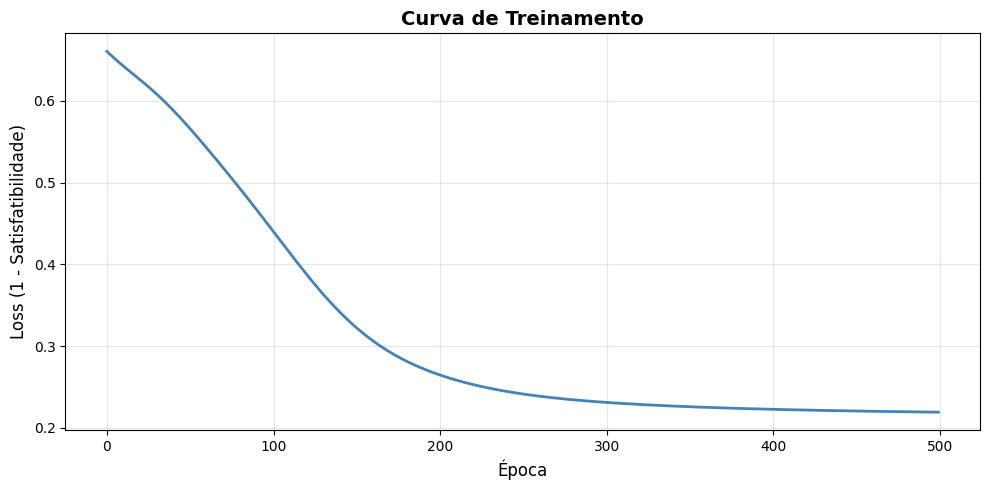

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history, linewidth=2, color='steelblue')
plt.xlabel('Época', fontsize=12)
plt.ylabel('Loss (1 - Satisfatibilidade)', fontsize=12)
plt.title('Curva de Treinamento', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 🔍 Queries Compostas (Tarefa 4)

Definição de consultas lógicas complexas para testar o raciocínio da rede:

1. **Query 1**: Existe objeto pequeno abaixo de cilindro E à esquerda de quadrado?
2. **Query 2**: Existe cone verde entre dois objetos?
3. **Query 3**: Se dois triângulos estão próximos, devem ter mesmo tamanho
4. **Opcional 1**: Existe objeto à esquerda de todos os quadrados?
5. **Opcional 2**: Todo quadrado está à direita de todo círculo?
6. **LastLeft**: Objeto mais à esquerda de todos
7. **LastRight**: Objeto mais à direita de todos


In [13]:
def query_composite_1(v_x, v_y, v_z):
    """
    Query 1: Existe objeto pequeno abaixo de cilindro E à esquerda de quadrado?

    Fórmula: ∃x(small(x) ∧ ∃y(cylinder(y) ∧ below(x,y)) ∧ ∃z(square(z) ∧ left(x,z)))
    """
    return Exists(v_x, And(
        IsSmall(v_x),
        And(
            Exists(v_y, And(IsCylinder(v_y), Below(v_x, v_y))),
            Exists(v_z, And(IsSquare(v_z), LeftOf(v_x, v_z)))
        )
    ))


def query_composite_2(v_x, v_y, v_z):
    """
    Query 2: Existe cone verde entre dois outros objetos?

    Fórmula: ∃x,y,z(cone(x) ∧ green(x) ∧ inBetween(x,y,z))
    """
    return Exists([v_x, v_y, v_z], And(
        IsCone(v_x),
        And(IsGreen(v_x), InBetween(v_x, v_y, v_z))
    ))


def query_composite_3(v_x, v_y):
    """
    Query 3: Se dois triângulos estão próximos, devem ter mesmo tamanho.

    Fórmula: ∀x,y((triangle(x) ∧ triangle(y) ∧ close(x,y)) ⟹ sameSize(x,y))
    """
    return Forall([v_x, v_y], Implies(
        And(IsTriangle(v_x), And(IsTriangle(v_y), CloseTo(v_x, v_y))),
        SameSize(v_x, v_y)
    ))


def query_optional_1(v_x, v_y):
    """
    Query Opcional 1: Existe objeto à esquerda de todos os quadrados?

    Fórmula: ∃x(∀y(square(y) ⟹ left(x,y)))
    """
    return Exists(v_x, Forall(v_y,
           Implies(IsSquare(v_y), LeftOf(v_x, v_y))))


def query_optional_2(v_x, v_y):
    """
    Query Opcional 2: Todo quadrado está à direita de todo círculo?

    Fórmula: ∀x,y((square(x) ∧ circle(y)) ⟹ right(x,y))
    """
    return Forall([v_x, v_y], Implies(
        And(IsSquare(v_x), IsCircle(v_y)),
        RightOf(v_x, v_y)
    ))


def query_last_left(v_x, v_y):
    """
    Objeto mais à esquerda de todos os outros (exceto ele mesmo).

    Fórmula: ∃x(∀y(¬equal(x,y) ⟹ left(x,y)))
    """
    return Exists(v_x, Forall(v_y,
        Implies(Not(Equal(v_x, v_y)), LeftOf(v_x, v_y))
    ))


def query_last_right(v_x, v_y):
    """
    Objeto mais à direita de todos os outros (exceto ele mesmo).

    Fórmula: ∃x(∀y(¬equal(x,y) ⟹ right(x,y)))
    """
    return Exists(v_x, Forall(v_y,
        Implies(Not(Equal(v_x, v_y)), RightOf(v_x, v_y))
    ))


print("✅ Queries compostas definidas!")


✅ Queries compostas definidas!


# 📊 Funções de Avaliação

Métricas para avaliar a performance dos predicados:
- **Accuracy**: Proporção de previsões corretas
- **Precision**: Proporção de positivos verdadeiros entre previsões positivas
- **Recall**: Proporção de positivos verdadeiros identificados
- **F1-Score**: Média harmônica entre precisão e recall


In [14]:
def calculate_metrics(y_true, y_pred):
    """
    Calcula todas as métricas de classificação.

    Args:
        y_true: Ground truth binário
        y_pred: Predições binárias

    Returns:
        dict: Dicionário com accuracy, precision, recall e f1
    """
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}


def evaluate_predicate(predicate, data, ground_truth, name="Predicate"):
    """
    Avalia um predicado unário contra ground truth.

    Args:
        predicate: Predicado LTN a avaliar
        data: Dados dos objetos
        ground_truth: Verdade esperada
        name: Nome do predicado (para logging)

    Returns:
        dict: Métricas de performance
    """
    with torch.no_grad():
        predictions = predicate(ltn.Variable("temp", data)).value.numpy() > 0.5

    metrics = calculate_metrics(ground_truth, predictions)
    return metrics


def evaluate_spatial_predicate(predicate_model, data, ground_truth, name="Spatial"):
    """
    Avalia um predicado binário (relação espacial).

    Args:
        predicate_model: Modelo do predicado espacial
        data: Dados dos objetos
        ground_truth: Matriz n×n de verdade esperada
        name: Nome do predicado

    Returns:
        dict: Métricas de performance
    """
    n = data.shape[0]

    # Criar grade de pares de objetos
    grid_x = data.repeat_interleave(n, dim=0)
    grid_y = data.repeat(n, 1)

    with torch.no_grad():
        predictions = predicate_model(grid_x, grid_y).detach().numpy().flatten() > 0.5

    gt_flat = ground_truth.numpy().flatten()
    metrics = calculate_metrics(gt_flat, predictions)
    return metrics


print("✅ Funções de avaliação definidas!")


✅ Funções de avaliação definidas!


# 💡 Sistema de Explicabilidade (Ponto Extra)

Gera explicações textuais sobre por que certas queries são satisfeitas ou não,
identificando objetos específicos e suas relações.


In [15]:
def generate_explanations(data, x_var, y_var, z_var, results):
    """
    Gera explicações textuais detalhadas para as queries principais.

    Args:
        data: Tensor com dados dos objetos
        x_var, y_var, z_var: Variáveis LTN
        results: Dicionário de resultados

    Returns:
        list: Lista de strings com explicações
    """
    explanations = []

    # ============================================
    # Explicação Query 1: Pequeno abaixo de cilindro E esquerda de quadrado
    # ============================================
    with torch.no_grad():
        small_mask = IsSmall(x_var).value.numpy() > 0.5
        cylinder_mask = IsCylinder(y_var).value.numpy() > 0.5
        square_mask = IsSquare(z_var).value.numpy() > 0.5

        small_indices = np.where(small_mask)[0]
        cylinder_indices = np.where(cylinder_mask)[0]
        square_indices = np.where(square_mask)[0]

        found_q1 = False
        for s_idx in small_indices:
            for c_idx in cylinder_indices:
                # Verificar se está abaixo
                if data[s_idx, 1] < data[c_idx, 1]:
                    for sq_idx in square_indices:
                        # Verificar se está à esquerda
                        if data[s_idx, 0] < data[sq_idx, 0]:
                            explanations.append(
                                f"Q1: Objeto {s_idx} (pequeno) está abaixo do objeto "
                                f"{c_idx} (cilindro) E à esquerda do objeto {sq_idx} "
                                f"(quadrado). ✓"
                            )
                            found_q1 = True
                            break
                if found_q1:
                    break
            if found_q1:
                break

        if not found_q1:
            explanations.append("Q1: Nenhum objeto pequeno satisfaz as condições. ✗")

    # ============================================
    # Explicação Query 2: Cone verde entre dois objetos
    # ============================================
    with torch.no_grad():
        cone_mask = IsCone(x_var).value.numpy() > 0.5
        green_mask = IsGreen(x_var).value.numpy() > 0.5

        green_cone_indices = np.where(cone_mask & green_mask)[0]

        if len(green_cone_indices) > 0:
            cone_idx = green_cone_indices[0]
            cone_x = data[cone_idx, 0].item()

            # Encontrar objetos à esquerda e à direita
            left_objs = [i for i in range(len(data))
                        if data[i, 0] < cone_x and i != cone_idx]
            right_objs = [i for i in range(len(data))
                         if data[i, 0] > cone_x and i != cone_idx]

            if left_objs and right_objs:
                explanations.append(
                    f"Q2: Objeto {cone_idx} é um cone verde em x={cone_x:.2f}, "
                    f"com objetos {left_objs[:2]} à esquerda e "
                    f"{right_objs[:2]} à direita. ✓"
                )
            else:
                explanations.append(
                    f"Q2: Cone verde {cone_idx} não está entre outros objetos. ✗"
                )
        else:
            explanations.append("Q2: Não existe cone verde no cenário. ✗")

    # ============================================
    # Explicação Query 3: Triângulos próximos mesmo tamanho
    # ============================================
    with torch.no_grad():
        triangle_mask = IsTriangle(x_var).value.numpy() > 0.5
        triangle_indices = np.where(triangle_mask)[0]

        if len(triangle_indices) >= 2:
            violations = []
            for i in range(len(triangle_indices)):
                for j in range(i+1, len(triangle_indices)):
                    idx1, idx2 = triangle_indices[i], triangle_indices[j]

                    # Calcular distância
                    dist = np.sqrt((data[idx1, 0] - data[idx2, 0])**2 +
                                  (data[idx1, 1] - data[idx2, 1])**2)

                    if dist < 0.3:  # Threshold de proximidade
                        size1 = data[idx1, 10].item()
                        size2 = data[idx2, 10].item()

                        if size1 != size2:
                            violations.append((idx1, idx2, dist, size1, size2))

            if violations:
                v = violations[0]
                explanations.append(
                    f"Q3: Triângulos {v[0]} e {v[1]} estão próximos (dist={v[2]:.2f}) "
                    f"mas têm tamanhos diferentes ({v[3]:.1f} vs {v[4]:.1f}). ✗"
                )
            else:
                explanations.append(
                    "Q3: Todos os triângulos próximos têm o mesmo tamanho. ✓"
                )
        else:
            explanations.append("Q3: Menos de 2 triângulos no cenário.")

    return explanations


print("✅ Sistema de explicabilidade implementado!")


✅ Sistema de explicabilidade implementado!


# 🧪 Validação em 5 Cenários Aleatórios

Conforme requisitado no trabalho, vamos avaliar o modelo treinado em 5 cenários
completamente novos e aleatórios para testar a capacidade de generalização.

Para cada cenário, mediremos:
- Métricas de todos os predicados (Accuracy, Precision, Recall, F1)
- Satisfatibilidade das queries compostas
- Explicações das queries principais



🧪 VALIDAÇÃO EM 5 CENÁRIOS ALEATÓRIOS

📊 CENÁRIO 1


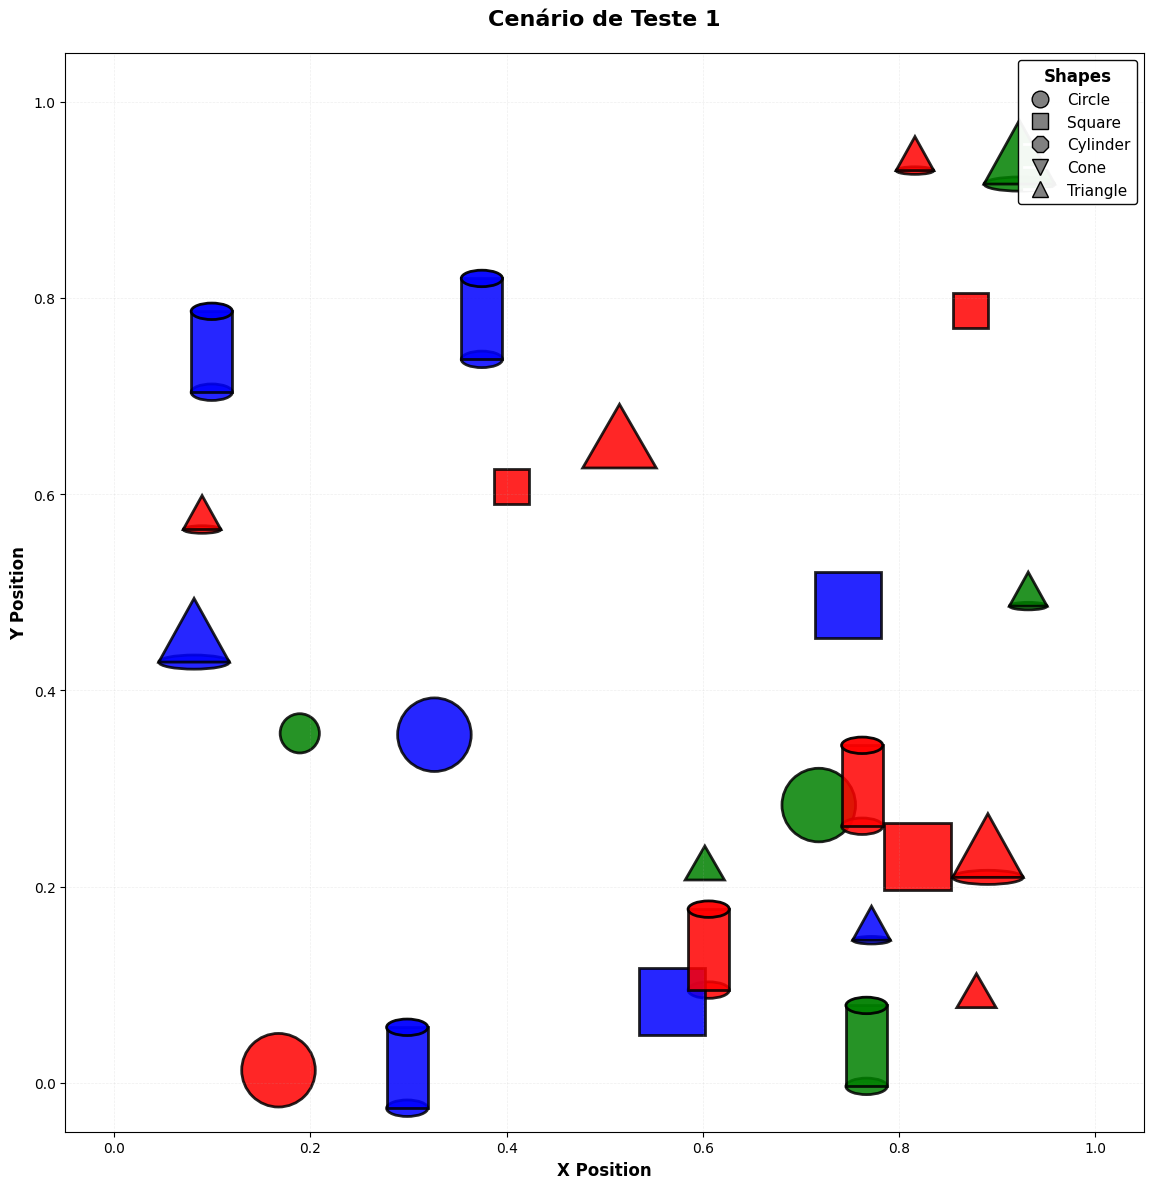


🔸 Predicados de Forma:
  IsCircle     | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsSquare     | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsCylinder   | Acc: 0.920 | Prec: 1.000 | Rec: 0.667 | F1: 0.800
  IsCone       | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsTriangle   | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000

🔸 Predicados de Cor:
  IsRed        | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsGreen      | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsBlue       | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000

🔸 Predicados de Tamanho:
  IsSmall    | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsBig      | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000

🔸 Predicados Espaciais:
  LeftOf     | Acc: 0.915 | Prec: 0.875 | Rec: 0.960 | F1: 0.916
  RightOf    | Acc: 0.904 | Prec: 0.866 | Rec: 0.947 | F1: 0.904
  Below      | Acc: 0.923 | Prec: 0.882 | Rec: 0.970 | F1: 0.924
  Above      | Acc: 0.926 | Prec: 0.885 | 

/tmp/ipython-input-2070129191.py:96: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dist = np.sqrt((data[idx1, 0] - data[idx2, 0])**2 +


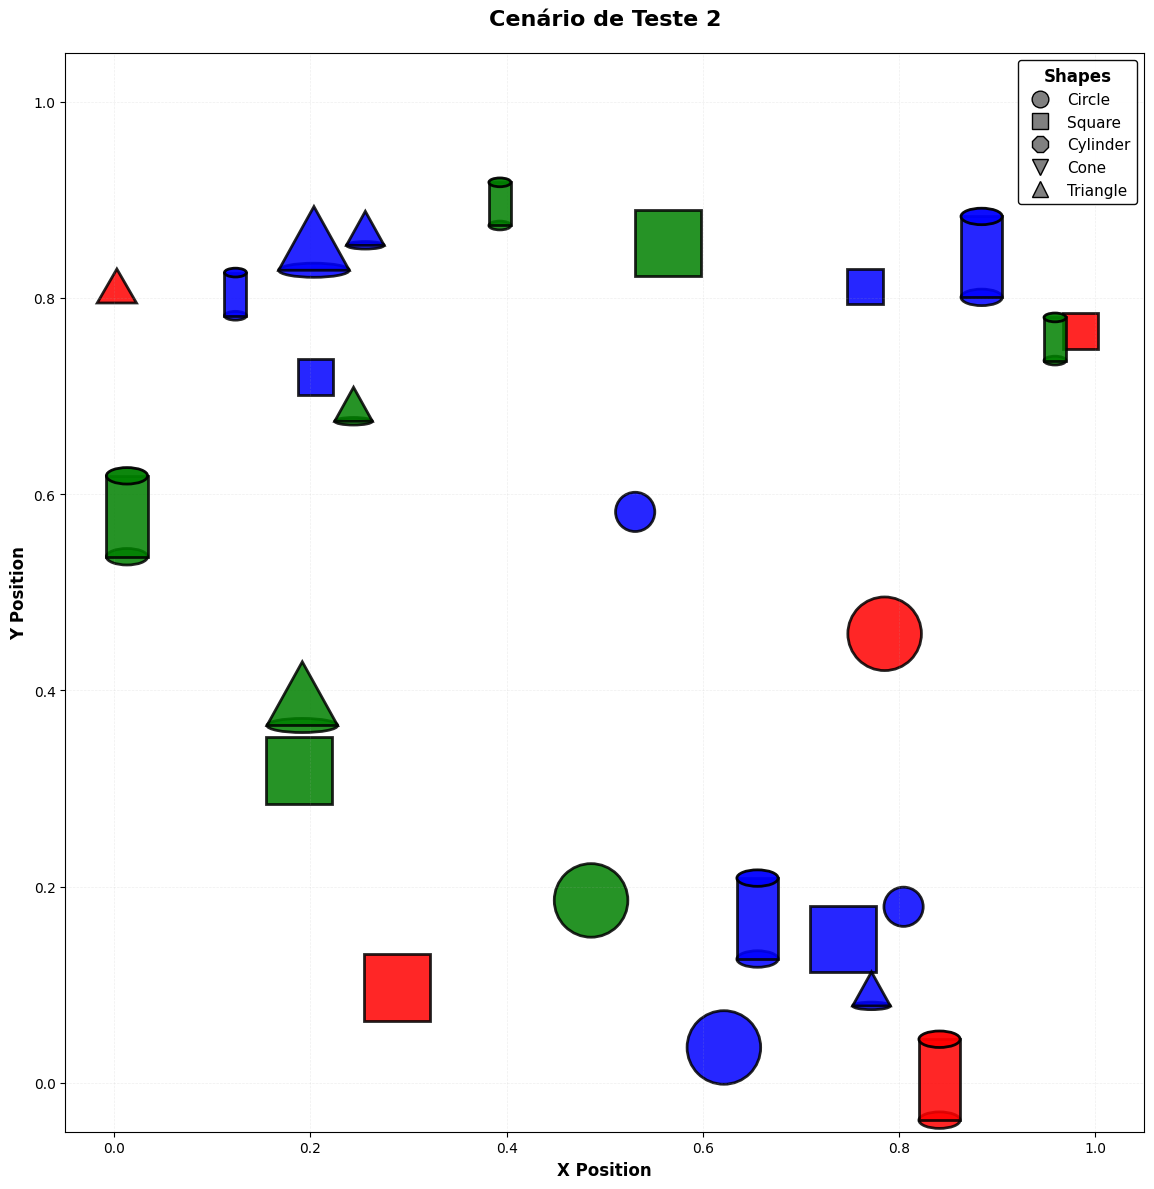


🔸 Predicados de Forma:
  IsCircle     | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsSquare     | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsCylinder   | Acc: 0.920 | Prec: 1.000 | Rec: 0.714 | F1: 0.833
  IsCone       | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsTriangle   | Acc: 0.960 | Prec: 0.000 | Rec: 0.000 | F1: 0.000

🔸 Predicados de Cor:
  IsRed        | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsGreen      | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsBlue       | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000

🔸 Predicados de Tamanho:
  IsSmall    | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsBig      | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000

🔸 Predicados Espaciais:
  LeftOf     | Acc: 0.936 | Prec: 0.896 | Rec: 0.980 | F1: 0.936
  RightOf    | Acc: 0.926 | Prec: 0.897 | Rec: 0.957 | F1: 0.926
  Below      | Acc: 0.922 | Prec: 0.870 | Rec: 0.983 | F1: 0.923
  Above      | Acc: 0.920 | Prec: 0.877 | 

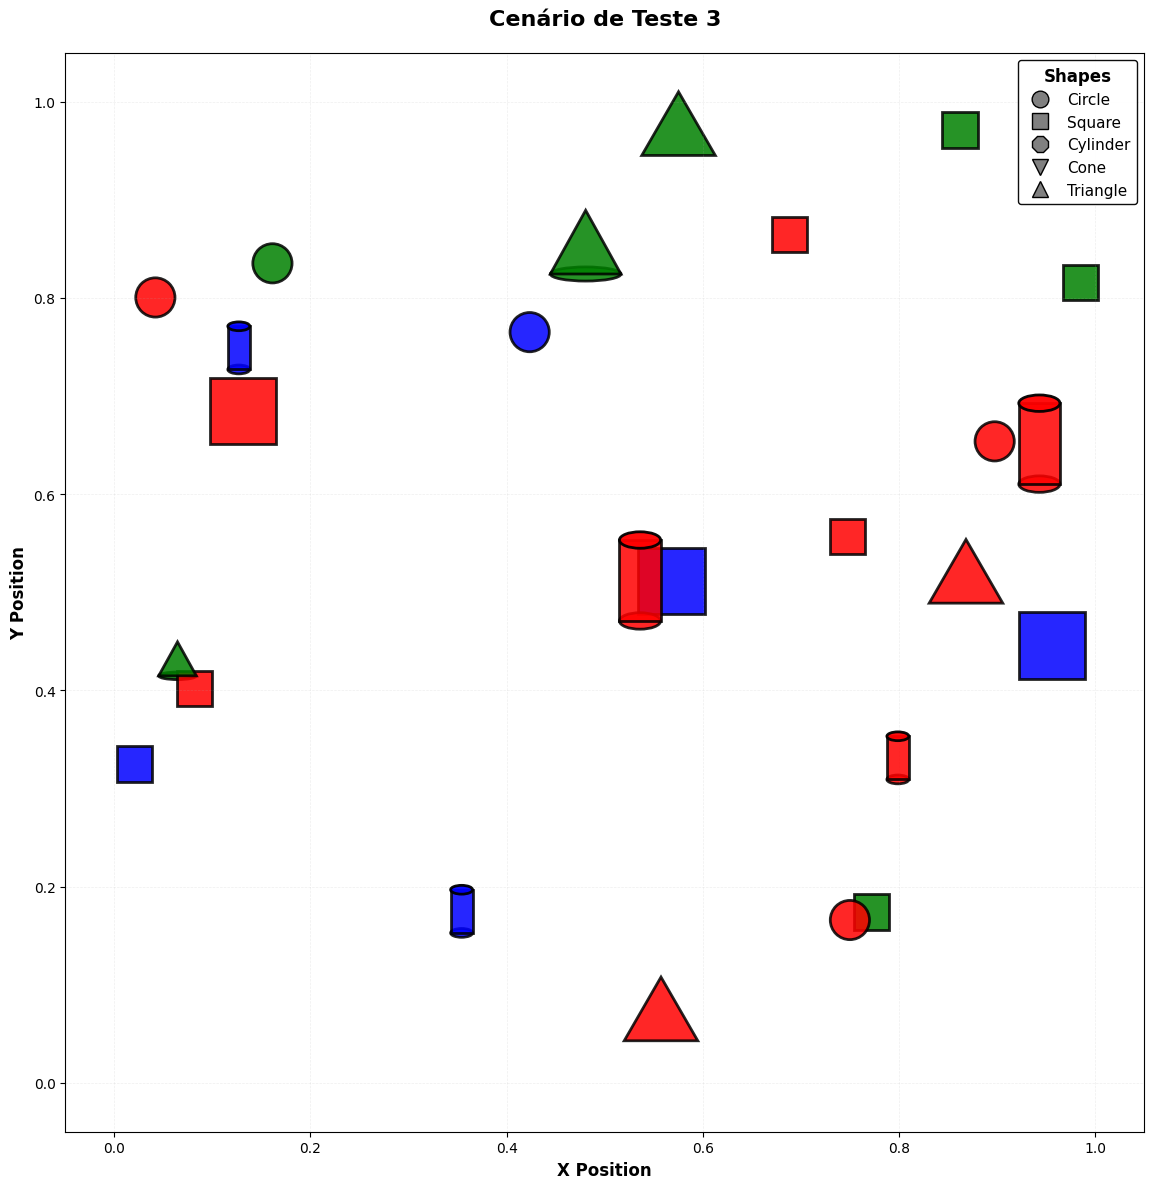


🔸 Predicados de Forma:
  IsCircle     | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsSquare     | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsCylinder   | Acc: 0.960 | Prec: 1.000 | Rec: 0.800 | F1: 0.889
  IsCone       | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsTriangle   | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000

🔸 Predicados de Cor:
  IsRed        | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsGreen      | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsBlue       | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000

🔸 Predicados de Tamanho:
  IsSmall    | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsBig      | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000

🔸 Predicados Espaciais:
  LeftOf     | Acc: 0.906 | Prec: 0.885 | Rec: 0.923 | F1: 0.904
  RightOf    | Acc: 0.902 | Prec: 0.892 | Rec: 0.907 | F1: 0.899
  Below      | Acc: 0.918 | Prec: 0.876 | Rec: 0.967 | F1: 0.919
  Above      | Acc: 0.928 | Prec: 0.888 | 

/tmp/ipython-input-2070129191.py:96: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dist = np.sqrt((data[idx1, 0] - data[idx2, 0])**2 +


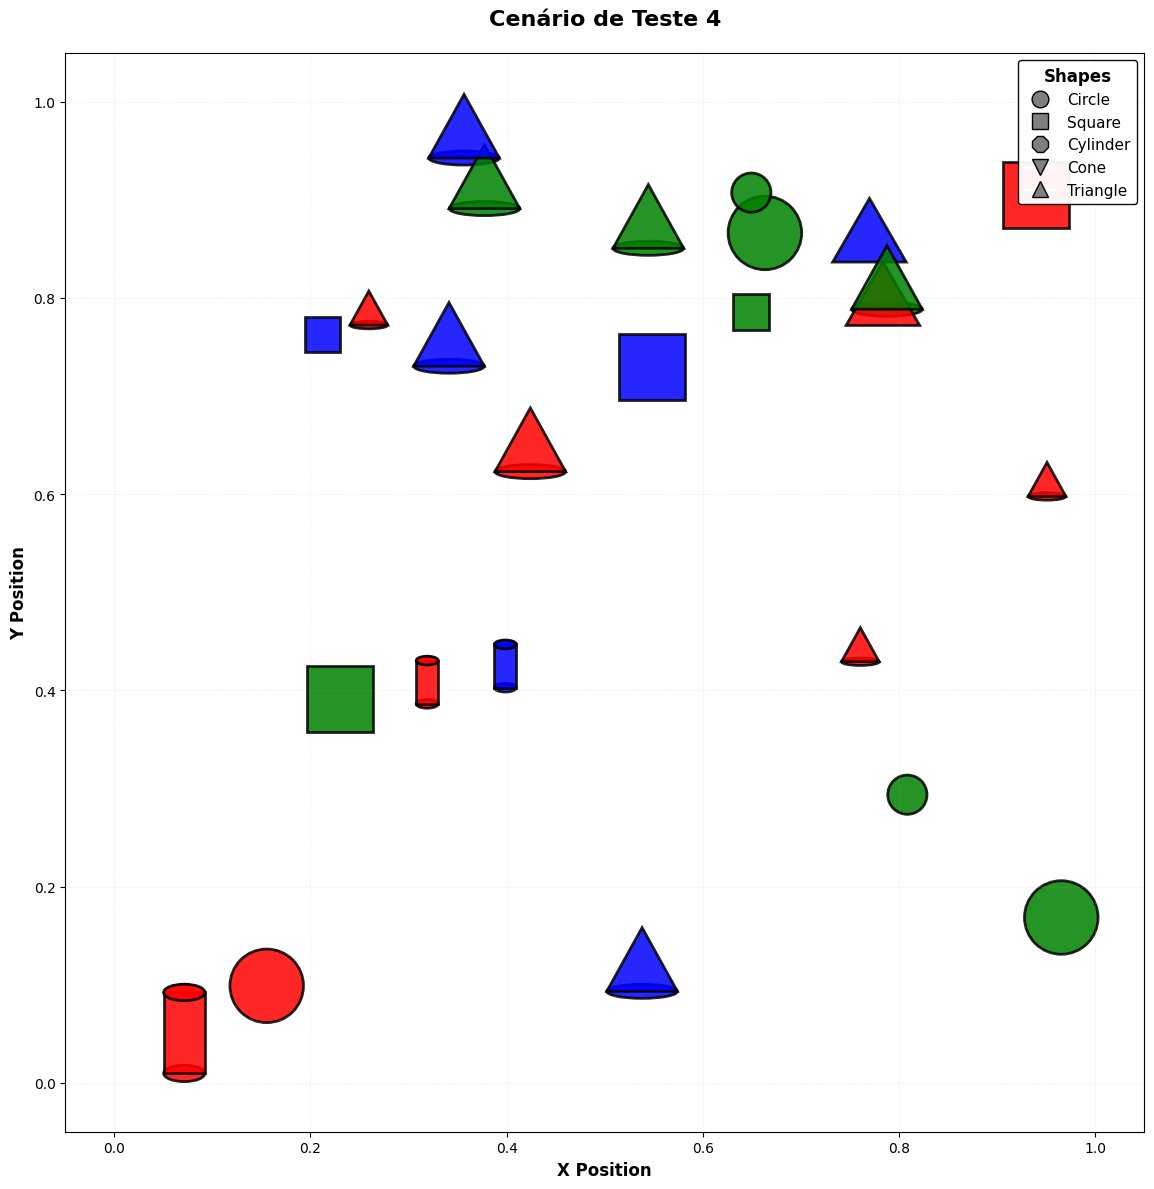


🔸 Predicados de Forma:
  IsCircle     | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsSquare     | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsCylinder   | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsCone       | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsTriangle   | Acc: 0.960 | Prec: 1.000 | Rec: 0.500 | F1: 0.667

🔸 Predicados de Cor:
  IsRed        | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsGreen      | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsBlue       | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000

🔸 Predicados de Tamanho:
  IsSmall    | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsBig      | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000

🔸 Predicados Espaciais:
  LeftOf     | Acc: 0.917 | Prec: 0.885 | Rec: 0.950 | F1: 0.916
  RightOf    | Acc: 0.922 | Prec: 0.884 | Rec: 0.963 | F1: 0.922
  Below      | Acc: 0.923 | Prec: 0.884 | Rec: 0.967 | F1: 0.924
  Above      | Acc: 0.915 | Prec: 0.869 | 

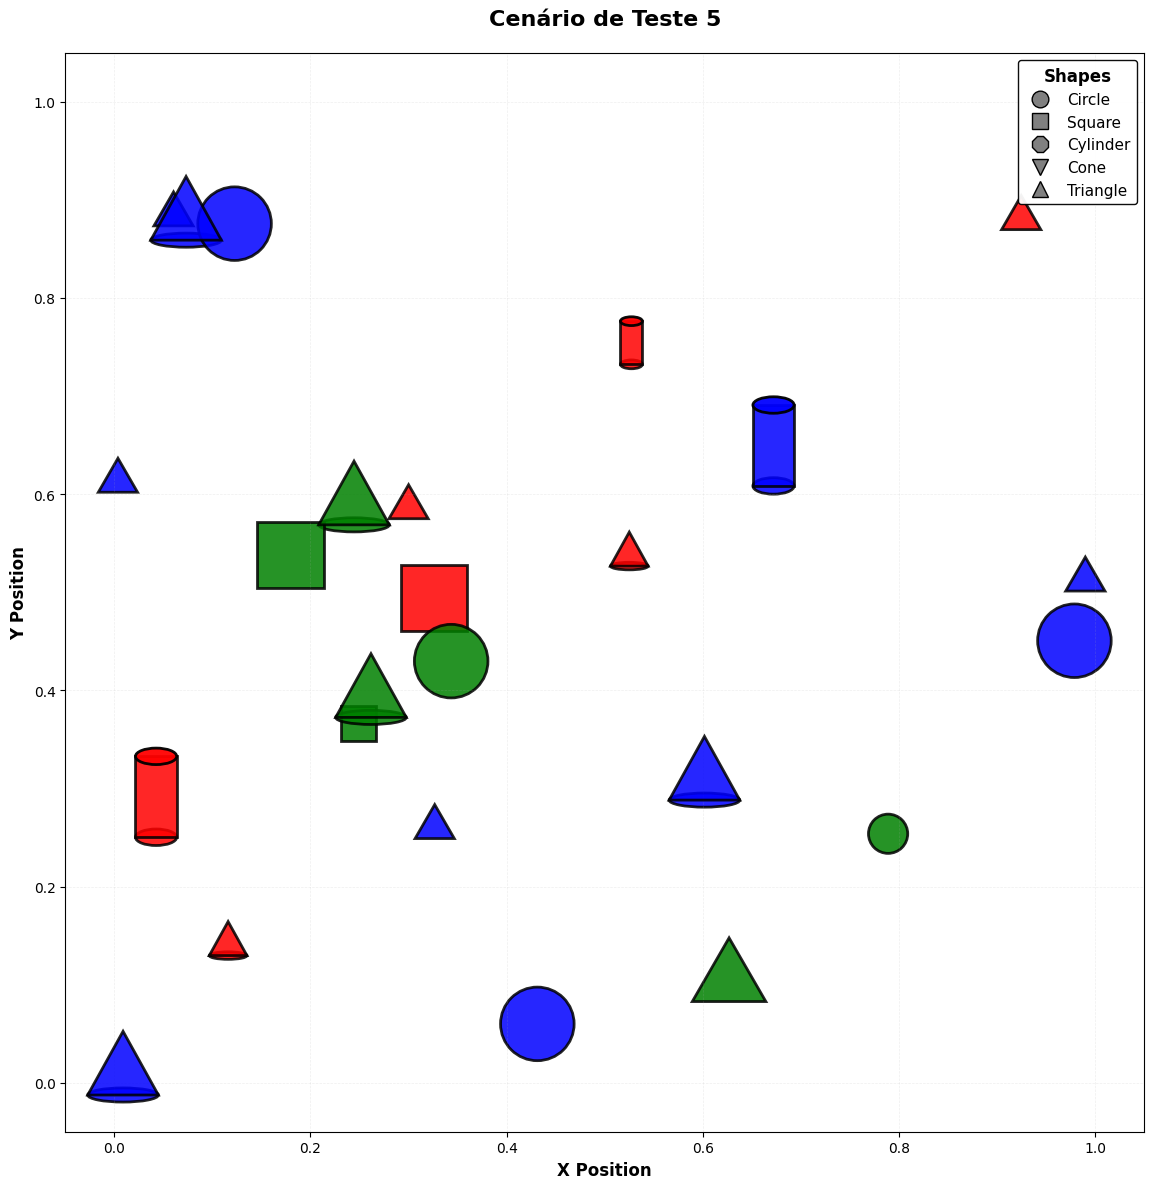


🔸 Predicados de Forma:
  IsCircle     | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsSquare     | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsCylinder   | Acc: 0.960 | Prec: 1.000 | Rec: 0.667 | F1: 0.800
  IsCone       | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsTriangle   | Acc: 0.960 | Prec: 1.000 | Rec: 0.857 | F1: 0.923

🔸 Predicados de Cor:
  IsRed        | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsGreen      | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsBlue       | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000

🔸 Predicados de Tamanho:
  IsSmall    | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000
  IsBig      | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000

🔸 Predicados Espaciais:
  LeftOf     | Acc: 0.928 | Prec: 0.890 | Rec: 0.970 | F1: 0.928
  RightOf    | Acc: 0.920 | Prec: 0.891 | Rec: 0.950 | F1: 0.919
  Below      | Acc: 0.922 | Prec: 0.881 | Rec: 0.967 | F1: 0.922
  Above      | Acc: 0.925 | Prec: 0.878 | 

/tmp/ipython-input-2070129191.py:96: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dist = np.sqrt((data[idx1, 0] - data[idx2, 0])**2 +


In [16]:
print("\n" + "="*60)
print("🧪 VALIDAÇÃO EM 5 CENÁRIOS ALEATÓRIOS")
print("="*60)

all_results = []

for scenario_idx in range(5):
    print(f"\n{'='*60}")
    print(f"📊 CENÁRIO {scenario_idx + 1}")
    print(f"{'='*60}")

    # ============================================
    # Gerar cenário de teste aleatório
    # ============================================
    data_test, shapes_gt, sizes_gt = data_gen.generate()

    # Visualizar cenário
    data_gen.plot_scene(data_test, f"Cenário de Teste {scenario_idx + 1}")

    # Criar variáveis LTN para este cenário
    x_test = ltn.Variable("x", data_test)
    y_test = ltn.Variable("y", data_test)
    z_test = ltn.Variable("z", data_test)

    # Dicionário para armazenar resultados
    results = {"scenario": scenario_idx + 1}

    # ============================================
    # AVALIAR PREDICADOS DE FORMA
    # ============================================
    print("\n🔸 Predicados de Forma:")

    for shape_idx, (predicate, name) in enumerate([
        (IsCircle, "Circle"), (IsSquare, "Square"), (IsCylinder, "Cylinder"),
        (IsCone, "Cone"), (IsTriangle, "Triangle")
    ]):
        gt = (shapes_gt == shape_idx).numpy()
        metrics = evaluate_predicate(predicate, data_test, gt, name)
        results[f"Is{name}"] = metrics
        print(f"  Is{name:10s} | Acc: {metrics['accuracy']:.3f} | "
              f"Prec: {metrics['precision']:.3f} | Rec: {metrics['recall']:.3f} | "
              f"F1: {metrics['f1']:.3f}")

    # ============================================
    # AVALIAR PREDICADOS DE COR
    # ============================================
    print("\n🔸 Predicados de Cor:")

    for color_idx, (predicate, name) in enumerate([
        (IsRed, "Red"), (IsGreen, "Green"), (IsBlue, "Blue")
    ]):
        gt = data_test[:, 2 + color_idx].numpy()
        metrics = evaluate_predicate(predicate, data_test, gt, name)
        results[f"Is{name}"] = metrics
        print(f"  Is{name:10s} | Acc: {metrics['accuracy']:.3f} | "
              f"Prec: {metrics['precision']:.3f} | Rec: {metrics['recall']:.3f} | "
              f"F1: {metrics['f1']:.3f}")

    # ============================================
    # AVALIAR PREDICADOS DE TAMANHO
    # ============================================
    print("\n🔸 Predicados de Tamanho:")

    gt_small = (sizes_gt == 0.0).numpy()
    gt_big = (sizes_gt == 1.0).numpy()

    metrics_small = evaluate_predicate(IsSmall, data_test, gt_small, "Small")
    metrics_big = evaluate_predicate(IsBig, data_test, gt_big, "Big")

    results["IsSmall"] = metrics_small
    results["IsBig"] = metrics_big

    print(f"  IsSmall    | Acc: {metrics_small['accuracy']:.3f} | "
          f"Prec: {metrics_small['precision']:.3f} | "
          f"Rec: {metrics_small['recall']:.3f} | F1: {metrics_small['f1']:.3f}")
    print(f"  IsBig      | Acc: {metrics_big['accuracy']:.3f} | "
          f"Prec: {metrics_big['precision']:.3f} | "
          f"Rec: {metrics_big['recall']:.3f} | F1: {metrics_big['f1']:.3f}")

    # ============================================
    # AVALIAR PREDICADOS ESPACIAIS
    # ============================================
    print("\n🔸 Predicados Espaciais:")

    # Ground Truth para relações espaciais
    x_coords = data_test[:, 0].unsqueeze(1)
    x_coords_t = data_test[:, 0].unsqueeze(0)
    gt_left = (x_coords < x_coords_t)
    gt_right = (x_coords > x_coords_t)

    y_coords = data_test[:, 1].unsqueeze(1)
    y_coords_t = data_test[:, 1].unsqueeze(0)
    gt_below = (y_coords < y_coords_t)
    gt_above = (y_coords > y_coords_t)

    # Avaliar relações horizontais e verticais
    metrics_left = evaluate_spatial_predicate(model_left, data_test, gt_left, "LeftOf")
    metrics_right = evaluate_spatial_predicate(model_right, data_test, gt_right, "RightOf")
    metrics_below = evaluate_spatial_predicate(model_below, data_test, gt_below, "Below")
    metrics_above = evaluate_spatial_predicate(model_above, data_test, gt_above, "Above")

    results["LeftOf"] = metrics_left
    results["RightOf"] = metrics_right
    results["Below"] = metrics_below
    results["Above"] = metrics_above

    print(f"  LeftOf     | Acc: {metrics_left['accuracy']:.3f} | "
          f"Prec: {metrics_left['precision']:.3f} | "
          f"Rec: {metrics_left['recall']:.3f} | F1: {metrics_left['f1']:.3f}")
    print(f"  RightOf    | Acc: {metrics_right['accuracy']:.3f} | "
          f"Prec: {metrics_right['precision']:.3f} | "
          f"Rec: {metrics_right['recall']:.3f} | F1: {metrics_right['f1']:.3f}")
    print(f"  Below      | Acc: {metrics_below['accuracy']:.3f} | "
          f"Prec: {metrics_below['precision']:.3f} | "
          f"Rec: {metrics_below['recall']:.3f} | F1: {metrics_below['f1']:.3f}")
    print(f"  Above      | Acc: {metrics_above['accuracy']:.3f} | "
          f"Prec: {metrics_above['precision']:.3f} | "
          f"Rec: {metrics_above['recall']:.3f} | F1: {metrics_above['f1']:.3f}")

    # ============================================
    # AVALIAR CanStack
    # ============================================
    print("\n🔸 Predicado CanStack:")

    # Ground truth: pode empilhar se y não é cone nem triângulo
    cone_mask = data_test[:, 8].numpy()
    triangle_mask = data_test[:, 9].numpy()

    n = data_test.shape[0]
    gt_canstack = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            can_stack = (cone_mask[j] == 0.0) and (triangle_mask[j] == 0.0)
            gt_canstack[i, j] = 1.0 if can_stack else 0.0

    gt_canstack_tensor = torch.tensor(gt_canstack, dtype=torch.float32)
    metrics_canstack = evaluate_spatial_predicate(
        model_stack, data_test, gt_canstack_tensor, "CanStack"
    )

    results["CanStack"] = metrics_canstack

    print(f"  CanStack   | Acc: {metrics_canstack['accuracy']:.3f} | "
          f"Prec: {metrics_canstack['precision']:.3f} | "
          f"Rec: {metrics_canstack['recall']:.3f} | "
          f"F1: {metrics_canstack['f1']:.3f}")

    # ============================================
    # AVALIAR QUERIES COMPOSTAS (TAREFA 4)
    # ============================================
    print("\n🔸 Queries Compostas:")

    with torch.no_grad():
        sat_q1 = query_composite_1(x_test, y_test, z_test).value.item()
        sat_q2 = query_composite_2(x_test, y_test, z_test).value.item()
        sat_q3 = query_composite_3(x_test, y_test).value.item()
        sat_opt1 = query_optional_1(x_test, y_test).value.item()
        sat_opt2 = query_optional_2(x_test, y_test).value.item()
        sat_last_left = query_last_left(x_test, y_test).value.item()
        sat_last_right = query_last_right(x_test, y_test).value.item()

    results["queries"] = {
        "Q1_small_below_cylinder_left_square": sat_q1,
        "Q2_green_cone_between": sat_q2,
        "Q3_triangles_close_same_size": sat_q3,
        "Optional1_exists_left_all_squares": sat_opt1,
        "Optional2_squares_right_circles": sat_opt2,
        "LastOnTheLeft": sat_last_left,
        "LastOnTheRight": sat_last_right
    }

    print(f"  Q1: Pequeno abaixo cilindro E esq. quadrado | Sat: {sat_q1:.3f}")
    print(f"  Q2: Cone verde entre dois objetos           | Sat: {sat_q2:.3f}")
    print(f"  Q3: Triângulos próximos mesmo tamanho       | Sat: {sat_q3:.3f}")
    print(f"  Opt1: Existe obj. esq. todos quadrados      | Sat: {sat_opt1:.3f}")
    print(f"  Opt2: Quadrados direita círculos            | Sat: {sat_opt2:.3f}")
    print(f"  LastLeft: Objeto mais à esquerda            | Sat: {sat_last_left:.3f}")
    print(f"  LastRight: Objeto mais à direita            | Sat: {sat_last_right:.3f}")

    # ============================================
    # EXPLICABILIDADE (PONTO EXTRA)
    # ============================================
    print("\n🔸 Explicações (Ponto Extra):")

    explanations = generate_explanations(data_test, x_test, y_test, z_test, results)
    results["explanations"] = explanations

    for exp in explanations[:3]:  # Mostrar primeiras 3 explicações
        print(f"  • {exp}")

    all_results.append(results)


# 📈 Consolidação dos Resultados

Análise estatística dos 5 cenários testados:
- Média e desvio padrão de todas as métricas
- Tabelas resumidas por categoria de predicado


In [17]:
print("\n" + "="*60)
print("📈 RESUMO CONSOLIDADO DOS 5 CENÁRIOS")
print("="*60)

# Calcular médias por predicado
metrics_summary = defaultdict(lambda: defaultdict(list))

for result in all_results:
    for pred_name, metrics in result.items():
        if pred_name not in ["scenario", "queries", "explanations"]:
            for metric_name, value in metrics.items():
                metrics_summary[pred_name][metric_name].append(value)

# ============================================
# Tabela: PREDICADOS UNÁRIOS
# ============================================
print("\n🔹 PREDICADOS UNÁRIOS:")
print(f"{'Predicado':<15} {'Accuracy':<10} {'Precision':<12} {'Recall':<10} {'F1-Score':<10}")
print("-" * 65)

for pred_name in ["IsCircle", "IsSquare", "IsCylinder", "IsCone", "IsTriangle",
                  "IsSmall", "IsBig", "IsRed", "IsGreen", "IsBlue"]:
    if pred_name in metrics_summary:
        avg_acc = np.mean(metrics_summary[pred_name]["accuracy"])
        avg_prec = np.mean(metrics_summary[pred_name]["precision"])
        avg_rec = np.mean(metrics_summary[pred_name]["recall"])
        avg_f1 = np.mean(metrics_summary[pred_name]["f1"])

        print(f"{pred_name:<15} {avg_acc:<10.3f} {avg_prec:<12.3f} "
              f"{avg_rec:<10.3f} {avg_f1:<10.3f}")

# ============================================
# Tabela: PREDICADOS ESPACIAIS
# ============================================
print("\n🔹 PREDICADOS ESPACIAIS:")
print(f"{'Predicado':<15} {'Accuracy':<10} {'Precision':<12} {'Recall':<10} {'F1-Score':<10}")
print("-" * 65)

for pred_name in ["LeftOf", "RightOf", "Below", "Above", "CanStack"]:
    if pred_name in metrics_summary:
        avg_acc = np.mean(metrics_summary[pred_name]["accuracy"])
        avg_prec = np.mean(metrics_summary[pred_name]["precision"])
        avg_rec = np.mean(metrics_summary[pred_name]["recall"])
        avg_f1 = np.mean(metrics_summary[pred_name]["f1"])

        print(f"{pred_name:<15} {avg_acc:<10.3f} {avg_prec:<12.3f} "
              f"{avg_rec:<10.3f} {avg_f1:<10.3f}")

# ============================================
# Tabela: QUERIES COMPOSTAS
# ============================================
print("\n🔹 QUERIES COMPOSTAS (SatAgg Médio):")
query_sats = defaultdict(list)

for result in all_results:
    for q_name, sat_val in result["queries"].items():
        query_sats[q_name].append(sat_val)

for q_name, sats in query_sats.items():
    avg_sat = np.mean(sats)
    std_sat = np.std(sats)
    print(f"  {q_name:<45} | Média: {avg_sat:.3f} ± {std_sat:.3f}")




📈 RESUMO CONSOLIDADO DOS 5 CENÁRIOS

🔹 PREDICADOS UNÁRIOS:
Predicado       Accuracy   Precision    Recall     F1-Score  
-----------------------------------------------------------------
IsCircle        1.000      1.000        1.000      1.000     
IsSquare        1.000      1.000        1.000      1.000     
IsCylinder      0.952      1.000        0.770      0.864     
IsCone          1.000      1.000        1.000      1.000     
IsTriangle      0.976      0.800        0.671      0.718     
IsSmall         1.000      1.000        1.000      1.000     
IsBig           1.000      1.000        1.000      1.000     
IsRed           1.000      1.000        1.000      1.000     
IsGreen         1.000      1.000        1.000      1.000     
IsBlue          1.000      1.000        1.000      1.000     

🔹 PREDICADOS ESPACIAIS:
Predicado       Accuracy   Precision    Recall     F1-Score  
-----------------------------------------------------------------
LeftOf          0.920      0.886       

# 💾 Exportação dos Resultados

Salvando todos os resultados em formato JSON para análise posterior.


In [18]:
with open("resultados_ltn.json", "w", encoding="utf-8") as f:
    json.dump(all_results, f, indent=2, ensure_ascii=False)

print("\n✅ Resultados salvos em 'resultados_ltn.json'")



✅ Resultados salvos em 'resultados_ltn.json'


# 📊 Visualizações Gráficas

Gráficos de barras para:
1. F1-Score médio de predicados unários
2. Satisfatibilidade média das queries compostas


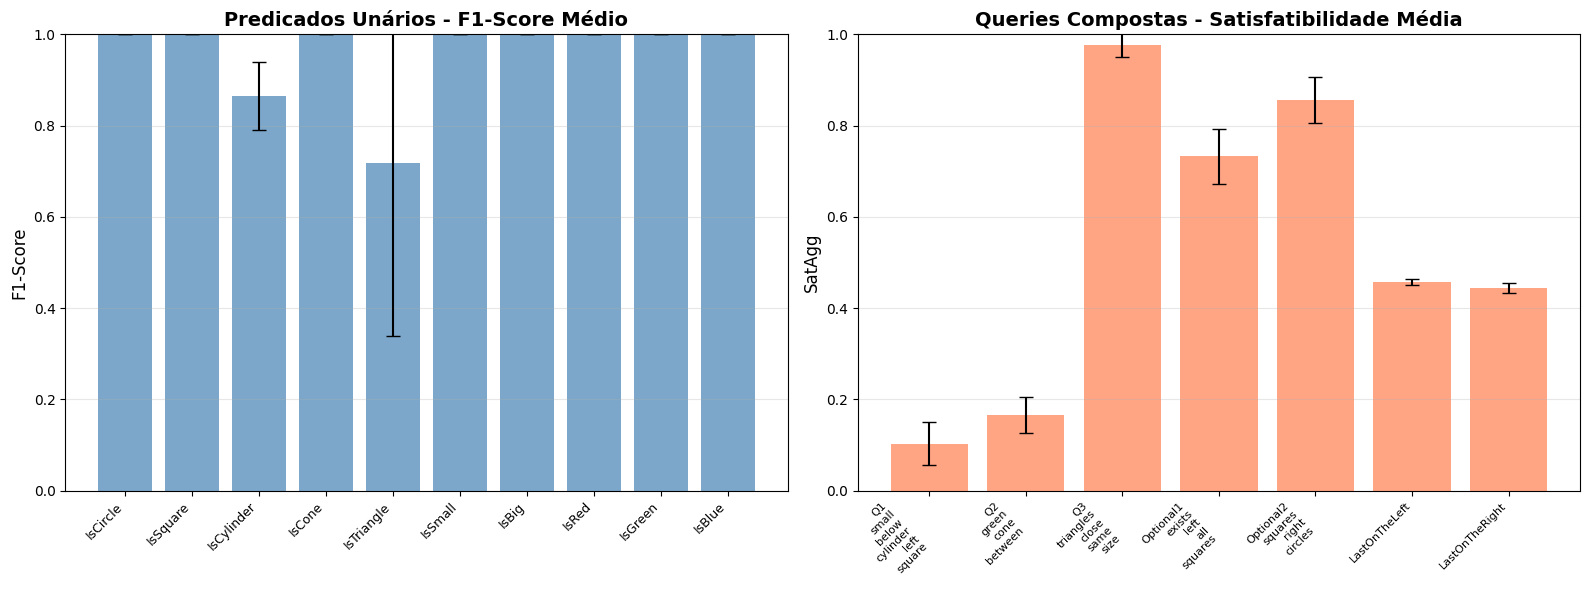

In [19]:
# Gráfico de F1-Score por Predicado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ============================================
# GRÁFICO 1: Predicados Unários
# ============================================
pred_names = ["IsCircle", "IsSquare", "IsCylinder", "IsCone", "IsTriangle",
              "IsSmall", "IsBig", "IsRed", "IsGreen", "IsBlue"]
f1_means = [np.mean(metrics_summary[p]["f1"]) for p in pred_names if p in metrics_summary]
f1_stds = [np.std(metrics_summary[p]["f1"]) for p in pred_names if p in metrics_summary]

axes[0].bar(range(len(f1_means)), f1_means, yerr=f1_stds,
            capsize=5, alpha=0.7, color='steelblue')
axes[0].set_xticks(range(len(pred_names)))
axes[0].set_xticklabels(pred_names, rotation=45, ha='right', fontsize=9)
axes[0].set_ylabel('F1-Score', fontsize=12)
axes[0].set_title('Predicados Unários - F1-Score Médio', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')

# ============================================
# GRÁFICO 2: Queries Compostas
# ============================================
query_names = list(query_sats.keys())
query_means = [np.mean(query_sats[q]) for q in query_names]
query_stds = [np.std(query_sats[q]) for q in query_names]

axes[1].bar(range(len(query_means)), query_means, yerr=query_stds,
            capsize=5, alpha=0.7, color='coral')
axes[1].set_xticks(range(len(query_names)))
axes[1].set_xticklabels([q.replace("_", "\n") for q in query_names],
                        rotation=45, ha='right', fontsize=8)
axes[1].set_ylabel('SatAgg', fontsize=12)
axes[1].set_title('Queries Compostas - Satisfatibilidade Média',
                  fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


Experimentos concluídos com sucesso! O modelo foi:

1. ✅ Treinado em um dataset fixo de 25 objetos
2. ✅ Validado em 5 cenários aleatórios diferentes
3. ✅ Avaliado em predicados unários (formas, cores, tamanhos)
4. ✅ Avaliado em predicados espaciais (LeftOf, RightOf, Below, Above, CanStack)
5. ✅ Testado com queries compostas complexas
6. ✅ Equipado com sistema de explicabilidade (Ponto Extra)

## Arquivos Gerados:
- `resultados_ltn.json`: Todos os resultados numéricos


In [20]:
print("\n" + "="*60)
print("✅ FIM DOS TESTES - TODOS OS EXPERIMENTOS CONCLUÍDOS!")
print("="*60)
print("\n📦 Arquivos gerados:")
print("  - resultados_ltn.json (resultados completos)")
print("\n🎯 Métricas principais calculadas:")
print("  ✓ Accuracy, Precision, Recall, F1-Score")
print("  ✓ Satisfatibilidade de axiomas e queries")
print("  ✓ Explicações textuais (Ponto Extra)")
print("\n📊 Visualizações geradas:")
print("  ✓ Curva de treinamento")
print("  ✓ Cenários de teste (5 plots)")
print("  ✓ Gráficos de F1-Score e Satisfatibilidade")


✅ FIM DOS TESTES - TODOS OS EXPERIMENTOS CONCLUÍDOS!

📦 Arquivos gerados:
  - resultados_ltn.json (resultados completos)

🎯 Métricas principais calculadas:
  ✓ Accuracy, Precision, Recall, F1-Score
  ✓ Satisfatibilidade de axiomas e queries
  ✓ Explicações textuais (Ponto Extra)

📊 Visualizações geradas:
  ✓ Curva de treinamento
  ✓ Cenários de teste (5 plots)
  ✓ Gráficos de F1-Score e Satisfatibilidade
